In [130]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

In [48]:
# Class Point
class Point:
    def __init__(self, x, y, color=None):
        self.x = x
        self.y = y
        self.color = color
    
    def __str__(self):
        return "Point: (" + str(self.x) + ", " + str(self.y) + ")" + " | " + str(self.color)

In [49]:
# Class Colored Vertex (3-color graph coloring)
class Vertex(Point):
    def __init__(self, x, y, color=None, vertex_type=None):
        super().__init__(x, y, color)
        self.vertex_type = vertex_type    
        
    def __str__(self):
        return super().__str__() + " | " + str(self.vertex_type)
    
    def __eq__(self, other):
        if isinstance(other, Vertex):
            return self.x == other.x and self.y == other.y
        return False

In [50]:
# Class for Linked Structure of Vertex implemented as doubly linked list
class LinkedNode:
    def __init__(self, vertex):
        self.data = vertex
        self.prev = None
        self.next = None
        
    def __str__(self):
        return self.data.__str__()

In [222]:
# Class Double Linked List - Representation for Convex, Reflex and Ear Nodes of the Polygon
class DoubleLinkedList:
    def __init__(self):
        self.head = None
        self.length = 0
        
    # insert at the end
    def add_node(self, node):
        
        self.length = self.length + 1
        
        if self.head == None:
            self.head = node
        else:
            node.prev = self.head.prev
            self.head.prev.next = node
            
        # make it cyclic
        node.next = self.head
        self.head.prev = node
            
    
    def remove_node(self, node):
        
        # fail if no nodes are present
        if self.length <= 0:
            raise Exception("Attempt to delete from an empty list!")
            
        # decrement the count optimistically
        self.length = self.length - 1
        
        if self.head == self.head.next:
            self.head = None
            return
        
        # check if head is being deleted
        if self.head == node:
            self.head.next.prev = self.head.prev
            self.head.prev.next = self.head.next
            self.head = node.next
            return
        
        current = self.head.next
        while True:
            if current == node:
                current.next.prev = current.prev
                current.prev.next = current.next
                break
            
            current = current.next
            
            # if element not found after one iteration of the chain
            if current == self.head:
                self.length = self.length + 1
                raise Exception("Node not found!")
             
        
    def list_nodes(self):
        if self.length > 0:
            current = self.head
            while True:
                print(current)
                current = current.next
                if current == self.head:
                    break
    
    
    def __iter__(self):
        if self.length > 0:
            current = self.head
            while True:
                yield current
                current = current.next
                if current == self.head:
                    break

In [394]:
# Class Polygon
class Polygon:
    def __init__(self, vertices):
        # vertices object is a double linked list structure of Vertex Linked Node
        self.vertices = vertices
  
        # classify all vertices as convex, ear or reflex
        self.__classify_vertices()
    
    
    def __classify_vertices(self):
        for vertex in self.vertices:
            if self.__is_convex(vertex.prev, vertex, vertex.next):
                vertex.data.vertex_type = "convex"
            else:
                vertex.data.vertex_type = "reflex"
                
        # check for ear vertices
        for vertex in self.vertices:
            if self.__is_ear(vertex, vertex.prev, vertex.next):
                vertex.data.vertex_type = "ear"
                
    
    def get_vertex_type(self, vertex, prev_vertex, next_vertex):
        if self.__is_convex(prev_vertex, vertex, next_vertex):
            # check if its ear
            if self.__is_ear(vertex, prev_vertex, next_vertex):
                return "ear"
        else:
            return "reflex"
        return "convex"

    
    def __is_convex(self, vertex1, vertex2, vertex3):
        angle = calculate_angle(vertex1.data, vertex2.data, vertex3.data)
        return angle <= 180
        
        
    def __is_ear(self, vertex, prev_vertex, next_vertex):
        # a vetex cannot be ear if it is reflex
        if vertex.data.vertex_type == "reflex":
            return False
        triangle = (vertex.data, prev_vertex.data, next_vertex.data)
        for v in self.vertices:
            # only a reflex vertex can be inside a triangle
            if v.data.vertex_type == "reflex":
                if v.data == prev_vertex.data or v.data == next_vertex.data:
                    continue
                if is_within_triangle(triangle, v.data):
                    return False
        return True        

    
    def print_vertices(self):
        self.vertices.list_nodes()

In [353]:
# Utility Functions
def is_within_triangle(triangle, vertex):
        triangle_area = calculate_area(triangle[0], triangle[1], triangle[2])
        sub_area_1 = calculate_area(triangle[0], triangle[1], vertex)
        sub_area_2 = calculate_area(triangle[0], triangle[2], vertex)
        sub_area_3 = calculate_area(triangle[1], triangle[2], vertex)
        
        return True if triangle_area == sub_area_1 + sub_area_2 + sub_area_3 else False
        
def calculate_area(vertex1, vertex2, vertex3):
    return abs((vertex1.x * (vertex2.y - vertex3.y) + vertex2.x * (vertex3.y - vertex1.y)
                + vertex3.x * (vertex1.y - vertex2.y)) / 2.0)

def calculate_angle(vertex1, vertex2, vertex3):
    angle_1 = math.atan2((vertex3.y-vertex2.y),(vertex3.x-vertex2.x))
    angle_2 = math.atan2((vertex1.y-vertex2.y),(vertex1.x-vertex2.x))
    angle_at_vertex2 = math.degrees(angle_1-angle_2)
    if angle_at_vertex2 == 180:
        return False
    return angle_at_vertex2 + 360 if angle_at_vertex2 < 0 else angle_at_vertex2

In [395]:
class TriangulatedPolygon:
    def __init__(self, polygon):
        self.polygon = polygon
        self.traingulated_vertices = []
        self.visited = {}
        
        # clone the polygon
        self.cloned_polygon = deepcopy(self.polygon)
        
    def triangulate(self):
        # vertices are chosen (n-3) times, when n is the vertices length of the polygon
        i = 0
        while i < self.polygon.vertices.length - 3:
            triangle = []
            # randomly choose an ear vertex and add it and its neghbours to the list
            for vertex in self.cloned_polygon.vertices:
                if vertex not in self.visited and vertex.data.vertex_type == "ear":
                    self.visited[vertex] = True
                    triangle.append(vertex)
                    triangle.append(vertex.prev)
                    triangle.append(vertex.next)
                    
                    self.traingulated_vertices.append(triangle)
                    
                    # recompute the vertex type of its neighbours
                    vertex.prev.data.vertex_type = self.cloned_polygon.get_vertex_type(vertex.prev, vertex.prev.prev, vertex.next)
                    vertex.next.data.vertex_type = self.cloned_polygon.get_vertex_type(vertex.next, vertex.prev, vertex.next.next)
                 
                    # remove the current vertex from the linked list
                    self.cloned_polygon.vertices.remove_node(vertex)
 
                    break
            i = i+1
            
        triangle = [self.cloned_polygon.vertices.head, self.cloned_polygon.vertices.head.next, self.cloned_polygon.vertices.head.next.next]
        self.traingulated_vertices.append(triangle)
            
    def print_triangulation(self):
        for vertex in self.traingulated_vertices:
            print(vertex[0])
            print(vertex[1])
            print(vertex[2])
            print("--------")

In [396]:
# Create vertices
vertices = [
    Vertex(0,0),
    Vertex(1,1),
    Vertex(2,4),
    Vertex(3,3),
    Vertex(6,7),
    Vertex(7,6),
    Vertex(9,7),
    Vertex(10,5),
    Vertex(8,3),
    Vertex(9,-1),
    Vertex(11,0),
    Vertex(14,5),
    Vertex(16,7),
    Vertex(18,5),
    Vertex(17,-9),
    Vertex(12,-8),
    Vertex(10,-6),
    Vertex(7,-6),
    Vertex(8,-10),
    Vertex(12,-10),
    Vertex(10,-12),
    Vertex(6,-10),
    Vertex(6,-2),
    Vertex(5,-3),
    Vertex(4,-2),
    Vertex(2,-2),
    Vertex(3,-3),
    Vertex(4,-5),
    Vertex(3,-7),
    Vertex(-2,-2),
    Vertex(-4,-1),
]

# vertices = [
#     Vertex(0,0),
#     Vertex(2,2),
#     Vertex(4,0),
#     Vertex(2,1)
# ]

linked_vertices = DoubleLinkedList()

for vertex in vertices:
    linked_vertex = LinkedNode(vertex)
    linked_vertices.add_node(linked_vertex)

linked_vertices.list_nodes()

Point: (0, 0) | None | None
Point: (1, 1) | None | None
Point: (2, 4) | None | None
Point: (3, 3) | None | None
Point: (6, 7) | None | None
Point: (7, 6) | None | None
Point: (9, 7) | None | None
Point: (10, 5) | None | None
Point: (8, 3) | None | None
Point: (9, -1) | None | None
Point: (11, 0) | None | None
Point: (14, 5) | None | None
Point: (16, 7) | None | None
Point: (18, 5) | None | None
Point: (17, -9) | None | None
Point: (12, -8) | None | None
Point: (10, -6) | None | None
Point: (7, -6) | None | None
Point: (8, -10) | None | None
Point: (12, -10) | None | None
Point: (10, -12) | None | None
Point: (6, -10) | None | None
Point: (6, -2) | None | None
Point: (5, -3) | None | None
Point: (4, -2) | None | None
Point: (2, -2) | None | None
Point: (3, -3) | None | None
Point: (4, -5) | None | None
Point: (3, -7) | None | None
Point: (-2, -2) | None | None
Point: (-4, -1) | None | None


In [398]:
# Create Polygon
polygon = Polygon(linked_vertices)
polygon.print_vertices()

Point: (0, 0) | None | reflex
Point: (1, 1) | None | reflex
Point: (2, 4) | None | ear
Point: (3, 3) | None | reflex
Point: (6, 7) | None | ear
Point: (7, 6) | None | reflex
Point: (9, 7) | None | ear
Point: (10, 5) | None | ear
Point: (8, 3) | None | reflex
Point: (9, -1) | None | reflex
Point: (11, 0) | None | reflex
Point: (14, 5) | None | ear
Point: (16, 7) | None | ear
Point: (18, 5) | None | ear
Point: (17, -9) | None | ear
Point: (12, -8) | None | ear
Point: (10, -6) | None | reflex
Point: (7, -6) | None | reflex
Point: (8, -10) | None | reflex
Point: (12, -10) | None | ear
Point: (10, -12) | None | convex
Point: (6, -10) | None | convex
Point: (6, -2) | None | reflex
Point: (5, -3) | None | ear
Point: (4, -2) | None | reflex
Point: (2, -2) | None | reflex
Point: (3, -3) | None | ear
Point: (4, -5) | None | ear
Point: (3, -7) | None | ear
Point: (-2, -2) | None | reflex
Point: (-4, -1) | None | ear


In [399]:
# Create triangulation
triangulated_polygon = TriangulatedPolygon(polygon)
triangulated_polygon.triangulate()

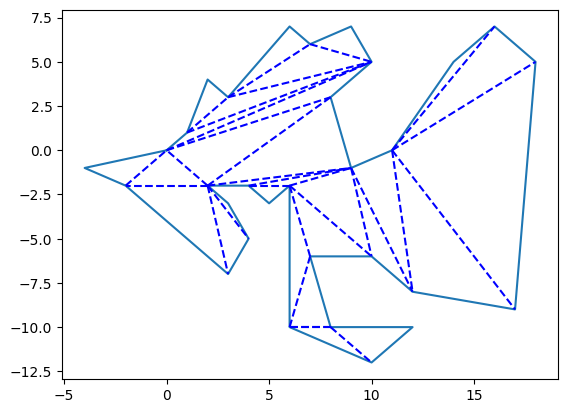

In [400]:
# Visualization

import matplotlib.pyplot as plt

# plotting the points

# colors = []
coordinates = []
for vertex in vertices:
    coordinates.append([vertex.x,vertex.y])

coordinates.append(coordinates[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coordinates) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 

# plot each triangle
for triangle in triangulated_polygon.traingulated_vertices:
    # get the x and y coordinates of the triangle vertices
    x_coords = [vertex.data.x for vertex in triangle[1:]]
    y_coords = [vertex.data.y for vertex in triangle[1:]]

    # plot the triangle using a blue line
    plt.plot(x_coords, y_coords, linestyle='dashed', color='blue')

plt.show()

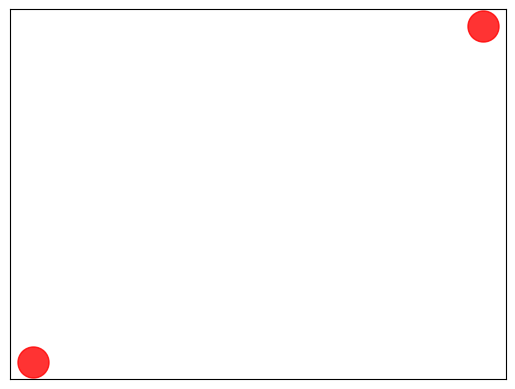

In [15]:
G=nx.Graph()

G.add_node(0,pos=(1,1))

G.add_node(1,pos=(2,2))

G.add_edge(0,1)

pos=nx.get_node_attributes(G,'pos')

# pos
# {1: (1, 1), 2: (2, 2)}

# nx.draw(G,pos,nodelist=[1,2],node_color='r')

nx.draw_networkx_nodes(G,pos,
                       nodelist=[0,1],
                       node_color='r',
                       node_size=500,
                    alpha=0.8)